ModernBert feature extractor for all targets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

df = pd.read_csv('../data/df_surprisal_final.csv')
target_columns = ['mistake_identification_label', 'mistake_location_label', 'providing_guidance_label', 'actionability_label']


model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)
model.eval()  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing BERT Embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}  
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean pooling
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

df['response_embeddings'] = list(get_bert_embeddings(df['response'].tolist(), batch_size=16))


X = np.array(df['response_embeddings'].tolist())
y = df[target_columns].values


c:\Users\Ana\miniconda3\envs\deep-l\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing BERT Embeddings: 100%|██████████| 150/150 [00:18<00:00,  8.18it/s]


In [ ]:
X.shape # embeddings (BERT output)  # 2400 samples, 768 BERT dimensions
y.shape # 2400 samples, 4 category labels - each with unique values 0,1,2 - multi-output (multi-class classification)

(2400, 4)

In [25]:
import numpy
numpy.savetxt("X-bert-embeddings-multioutput.csv", X, delimiter=",")
numpy.savetxt("y-multioutput.csv", y, delimiter=",")

LR and MLP as classifiers multioutput multiclass

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Logistic Regression
log_reg = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# MLP Classifier
mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, model_name):
    acc = np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y.shape[1])])
    f1 = np.mean([f1_score(y_true[:, i], y_pred[:, i], average='macro') for i in range(y.shape[1])])
    print(f"{model_name} - Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

evaluate(y_test, y_pred_log, "Logistic Regression")
evaluate(y_test, y_pred_mlp, "MLP Classifier")

Logistic Regression - Accuracy: 0.3469, Macro F1: 0.3464
MLP Classifier - Accuracy: 0.3375, Macro F1: 0.3363


In [307]:
X.shape # embeddings (BERT output)  # 2400 samples, 768 BERT dimensions
y.shape # 2400 samples, 1 category labels - each with unique values 0,1,2
y = y.squeeze()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# # MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{model_name} - Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

evaluate(y_test, y_pred_log, "Logistic Regression")
evaluate(y_test, y_pred_mlp, "MLP Classifier")

Logistic Regression - Accuracy: 0.8167, Macro F1: 0.5477
MLP Classifier - Accuracy: 0.8313, Macro F1: 0.5748


In [311]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['response'])

In [312]:
from scipy.sparse import hstack

X_combined = hstack([X_tfidf, X])

In [314]:
# print version of scikit-learn
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
y.shape

In [318]:
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(y_train):
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weight_dict

class_weights = get_class_weights(y_train)

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate(y_test, y_pred_rf, "Random Forest")


Random Forest - Accuracy: 0.8438, Macro F1: 0.4788


In [60]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost")


XGBoost - Accuracy: 0.8646, Macro F1: 0.5302


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=2000, early_stopping=True, learning_rate='adaptive', alpha=0.001, validation_fraction=0.3)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
evaluate(y_test, y_pred_mlp, "MLP Classifier Deep")

MLP Classifier Deep - Accuracy: 0.8646, Macro F1: 0.5356


In [116]:
from sklearn.decomposition import PCA

print(X.shape)
pca = PCA(n_components=500)  # Reduce to 50 features
X_pca = pca.fit_transform(X)
print(X_pca.shape)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
log_reg2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg2.fit(X_train_pca, y_train)
y_pred_log_pca = log_reg2.predict(X_test_pca)
evaluate(y_pred_log_pca, y_test, "Logistic Regression with PCA")
# evaluate(mlp, X_pca, y)

(2400, 768)
(2400, 500)
Logistic Regression with PCA - Accuracy: 0.7875, Macro F1: 0.5682


In [117]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.argmax(axis=1), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

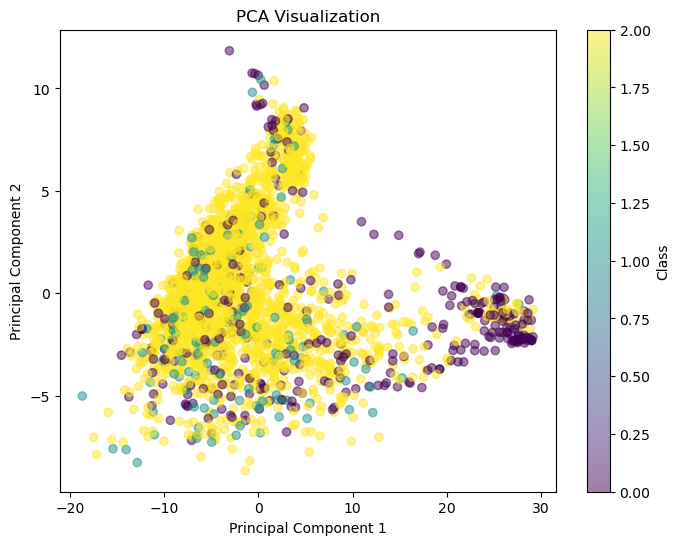

Explained variance ratio: 0.7371


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label="Class")
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Check variance retained
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")


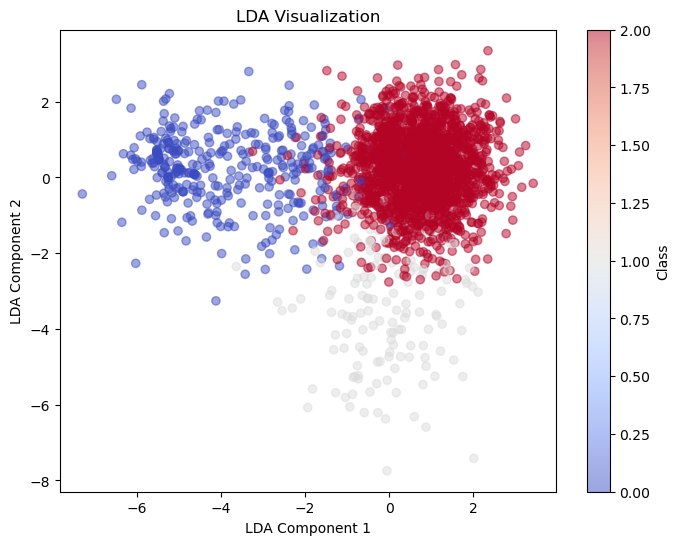

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Reduce to 2 dimensions using LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y) 

# Plot LDA results
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.colorbar(label="Class")
plt.title("LDA Visualization")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()


In [297]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
X_train_lda, X_test_lda, _, _ = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pca = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)

log_reg_lda = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_lda.fit(X_train_lda, y_train)
y_pred_lda = log_reg_lda.predict(X_test_lda)

def evaluate(y_pred, y_true, name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} - Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

evaluate(y_pred_pca, y_test, "Logistic Regression with PCA")
evaluate(y_pred_lda, y_test, "Logistic Regression with LDA")

Logistic Regression with PCA - Accuracy: 0.4917, Macro F1: 0.4014
Logistic Regression with LDA - Accuracy: 0.9187, Macro F1: 0.8323


In [181]:
import joblib
filename = 'log_reg_task1_lda2_task1_91_83.pkl'
joblib.dump(log_reg_lda, filename)

['log_reg_task1_lda2_task1_91_83.pkl']

In [183]:
log = joblib.load('log_reg_task1_lda2_task1_91_83.pkl')
y_pred_log = log.predict(X_test_lda)
evaluate(y_pred_log, y_test, "Logistic Regression with LDA")

Logistic Regression with LDA - Accuracy: 0.9187, Macro F1: 0.8323


In [290]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
X_train_lda, X_test_lda, _, _ = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)
# mlp with PCA
mlp_pca = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=1000, early_stopping=True, learning_rate='adaptive', alpha=0.001, validation_fraction=0.2, random_state=42)
mlp_pca.fit(X_train_pca, y_train)
y_pred_mlp_pca = mlp_pca.predict(X_test_pca)
evaluate(y_pred_mlp_pca, y_test, "MLP Classifier with PCA")

# mlp with LDA
mlp_lda = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=1000, early_stopping=True, learning_rate='adaptive', alpha=0.001, validation_fraction=0.2, random_state=42)
mlp_lda.fit(X_train_lda, y_train)
filename = 'mlp_task1.pkl'
joblib.dump(mlp_lda, filename)
y_pred_mlp_lda = mlp_lda.predict(X_test_lda)
evaluate(y_pred_mlp_lda, y_test, "MLP Classifier with LDA")

MLP Classifier with PCA - Accuracy: 0.8229, Macro F1: 0.4507
MLP Classifier with LDA - Accuracy: 0.9625, Macro F1: 0.8989


In [200]:
import pickle
filename = 'mlp_task1_lda2_96_89.pkl'
with open(filename, 'wb') as file:
    pickle.dump(mlp_lda, file)

In [296]:
model = joblib.load('mlp_task1.pkl')
ymlp = model.predict(X_test_lda)
evaluate(ymlp, y_test, "MLP Classifier with LDA")

MLP Classifier with LDA - Accuracy: 0.7771, Macro F1: 0.5478


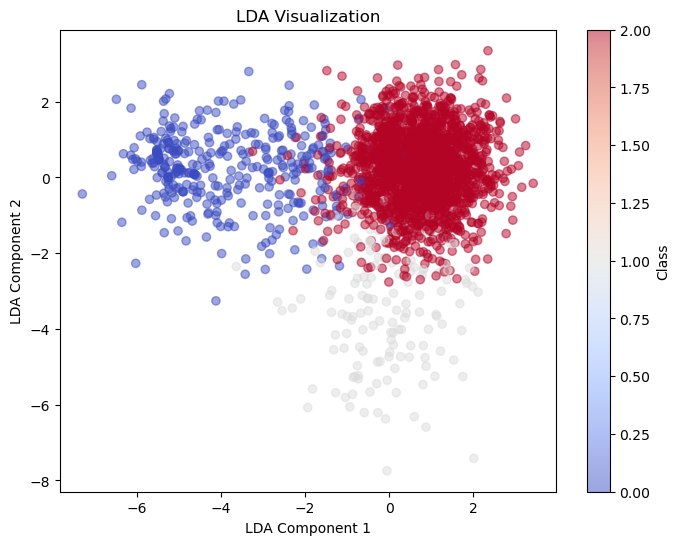

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Reduce to 2 dimensions using LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y) 

# Plot LDA results
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.colorbar(label="Class")
plt.title("LDA Visualization")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()


In [306]:
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pretrained_model = joblib.load('log_reg_task1_lda2_task1_91_83_t80-20.pkl')

# Define StratifiedKFold with n_splits=5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

# Perform Stratified K-Fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Apply LDA for dimensionality reduction
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    
    # Use the pre-trained model to make predictions
    y_pred = pretrained_model.predict(X_test_lda)
    
    # Evaluate performance
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))

# Print the results after cross-validation
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Macro F1: {np.mean(f1_scores):.4f}")


Accuracy: 0.6983
Macro F1: 0.5280


In [289]:
ymlp = pretrained_model.predict(X_test_lda)
evaluate(ymlp, y_test, "MLP Classifier with LDA")

MLP Classifier with LDA - Accuracy: 0.7771, Macro F1: 0.5478


In [304]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'accuracy': make_scorer(accuracy_score)
}

# Build pipeline: scale -> LDA -> MLP
pipeline = Pipeline([
    ('lda', LinearDiscriminantAnalysis(n_components=2)),
    ('mlp', MLPClassifier(max_iter=2000, early_stopping=True, random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(512, 256, 128, 64, 32), (256, 128, 64), (256, 128), (128,64)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['adaptive'],
    'mlp__solver': ['adam']
}

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    refit='f1_macro',
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

# Execute grid search
grid_search.fit(X, y)

# Output best scores and parameters
best_f1 = grid_search.best_score_
best_params = grid_search.best_params_
best_acc = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

(best_f1, best_acc, best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


(0.5697381050945436,
 0.7958333333333332,
 {'mlp__alpha': 0.01,
  'mlp__hidden_layer_sizes': (128, 64),
  'mlp__learning_rate': 'adaptive',
  'mlp__solver': 'adam'})